In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import numpy as np
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()#,
])

In [6]:
import os
import shutil
import random

ten_words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
roots = ['classes_unknown_bal/train', 'classes_unknown_bal/test', 'classes_unknown_bal/val']
sample_ratio = 0.05  # 5%

for root_dir in roots:
    print(f"\n--- Przetwarzanie: {root_dir} ---")

    unknown_path = os.path.join(root_dir, "unknown")
    os.makedirs(unknown_path, exist_ok=True)

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        if not os.path.isdir(folder_path) or folder in ten_words or folder == "unknown":
            continue

        # Pobierz tylko pliki .wav
        wav_files = [f for f in os.listdir(folder_path) if f.endswith(".png")]
        if not wav_files:
            print(f"Pomijam folder bez plików .wav: {folder}")
            shutil.rmtree(folder_path)
            continue

        # Próbkuj 5%
        sample_size = max(1, int(len(wav_files) * sample_ratio))  # min. 1 plik
        sampled_files = random.sample(wav_files, sample_size)

        print(f"{folder}: przenoszę {sample_size} .png do 'unknown'")

        for file in sampled_files:
            src_file = os.path.join(folder_path, file)
            dst_file = os.path.join(unknown_path, f"{folder}_{file}")
            shutil.move(src_file, dst_file)

        # Usuwamy cały folder po przeniesieniu (czyli kasujemy pozostałe 95%)
        shutil.rmtree(folder_path)
        print(f"Usunięto folder: {folder}")



--- Przetwarzanie: classes_unknown_bal/train ---
bed: przenoszę 59 .png do 'unknown'
Usunięto folder: bed
bird: przenoszę 60 .png do 'unknown'
Usunięto folder: bird
cat: przenoszę 60 .png do 'unknown'
Usunięto folder: cat
dog: przenoszę 62 .png do 'unknown'
Usunięto folder: dog
eight: przenoszę 79 .png do 'unknown'
Usunięto folder: eight
five: przenoszę 80 .png do 'unknown'
Usunięto folder: five
four: przenoszę 81 .png do 'unknown'
Usunięto folder: four
happy: przenoszę 61 .png do 'unknown'
Usunięto folder: happy
house: przenoszę 61 .png do 'unknown'
Usunięto folder: house
marvin: przenoszę 60 .png do 'unknown'
Usunięto folder: marvin
nine: przenoszę 80 .png do 'unknown'
Usunięto folder: nine
one: przenoszę 81 .png do 'unknown'
Usunięto folder: one
seven: przenoszę 82 .png do 'unknown'
Usunięto folder: seven
sheila: przenoszę 60 .png do 'unknown'
Usunięto folder: sheila
six: przenoszę 81 .png do 'unknown'
Usunięto folder: six
three: przenoszę 78 .png do 'unknown'
Usunięto folder: thre

In [7]:
train_set= ImageFolder(root='classes_unknown_bal\\train', transform=transform)
test_set = ImageFolder(root='classes_unknown_bal\\test', transform=transform)
val_set = ImageFolder(root='classes_unknown_bal\\val', transform=transform)

# Sprawdzenie etykiet (to jest przypisanie nazw folderów do etykiet)
class_names = train_set.classes
num_labels = len(class_names)
class_names


['down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'stop',
 'unknown',
 'up',
 'yes']

In [8]:
import torch.nn.init as init

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):  # Xavier dla warstw w pełni połączonych i konwolucyjnych
            init.xavier_uniform_(m.weight)  # Lub init.xavier_normal_(m.weight)
            if m.bias is not None:
                init.zeros_(m.bias)  # Biasy zerujemy


In [15]:

import timm
import torch.nn as nn
model = timm.create_model("deit_tiny_patch16_224")
model.head = nn.Linear(model.head.in_features, 11)  # Resetowanie klasyfikatora
initialize_weights(model)  # Xavier na nowej warstwie

model.patch_embed.proj = nn.Conv2d(1, 192, kernel_size=(16, 16), stride=(16, 16))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


Dataloading...
Epoch 1, Average Loss: 2.27622, Accuracy: 17.06%, last batch accuracy: 7.69% Time: 0.21ss
Epoch 1, Train Accuracy: 17.06%
Epoch 1, Validation Loss: 2.1089, Accuracy: 21.48%
Epoch 2, Average Loss: 1.87244, Accuracy: 32.19%, last batch accuracy: 69.23% Time: 0.11s
Epoch 2, Train Accuracy: 32.19%
Epoch 2, Validation Loss: 1.6590, Accuracy: 40.47%
Epoch 3, Average Loss: 1.50577, Accuracy: 46.74%, last batch accuracy: 53.85% Time: 0.11s
Epoch 3, Train Accuracy: 46.74%
Epoch 3, Validation Loss: 1.3683, Accuracy: 52.37%
Epoch 4, Average Loss: 1.27333, Accuracy: 55.25%, last batch accuracy: 61.54% Time: 0.11s
Epoch 4, Train Accuracy: 55.25%
Epoch 4, Validation Loss: 1.2808, Accuracy: 54.46%
Epoch 5, Average Loss: 1.13366, Accuracy: 60.59%, last batch accuracy: 53.85% Time: 0.11s
Epoch 5, Train Accuracy: 60.59%
Epoch 5, Validation Loss: 1.2732, Accuracy: 55.58%
Epoch 6, Average Loss: 1.03477, Accuracy: 63.93%, last batch accuracy: 61.54% Time: 0.11ss
Epoch 6, Train Accuracy: 63.9

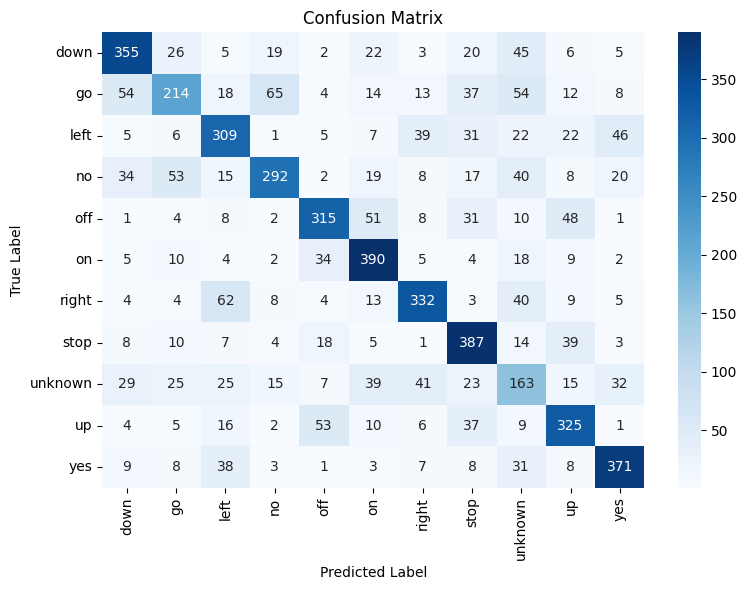

In [16]:

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Jeśli używasz CUDA, ustaw również seed dla GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Dla wszystkich urządzeń CUDA
    torch.backends.cudnn.deterministic = True  # Zapewnia deterministyczność
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  # <-- Przesyłanie X na odpowiednie urządzenie
        Y = batch_Y.to(device, non_blocking=True)  # <-- Przesyłanie Y na odpowiednie urządzenie
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():  # Wyłączenie śledzenia gradientów
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Zbieranie predykcji i prawdziwych etykiet
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Precision i Recall per klasa
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

    # Pobierz nazwy klas
    classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

    # Tabelka z wynikami
    df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 224 -> 112
        x = self.pool(F.relu(self.conv2(x)))  # 112 -> 56
        x = self.pool(F.relu(self.conv3(x)))  # 56 -> 28
        x = x.view(x.size(0), -1)             # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


Dataloading...
Epoch 1, Average Loss: 1.62322, Accuracy: 44.71%, last batch accuracy: 53.85% Time: 0.48s
Epoch 1, Train Accuracy: 44.71%
Epoch 1, Validation Loss: 1.2053, Accuracy: 60.87%
Epoch 2, Average Loss: 1.13688, Accuracy: 61.68%, last batch accuracy: 76.92% Time: 0.02s
Epoch 2, Train Accuracy: 61.68%
Epoch 2, Validation Loss: 0.9637, Accuracy: 68.56%
Epoch 3, Average Loss: 0.88744, Accuracy: 70.12%, last batch accuracy: 84.62% Time: 0.02s
Epoch 3, Train Accuracy: 70.12%
Epoch 3, Validation Loss: 0.8417, Accuracy: 73.00%
Epoch 4, Average Loss: 0.70433, Accuracy: 76.11%, last batch accuracy: 69.23% Time: 0.02s
Epoch 4, Train Accuracy: 76.11%
Epoch 4, Validation Loss: 0.7502, Accuracy: 75.90%
Epoch 5, Average Loss: 0.55699, Accuracy: 80.93%, last batch accuracy: 84.62% Time: 0.02ss
Epoch 5, Train Accuracy: 80.93%
Epoch 5, Validation Loss: 0.7413, Accuracy: 76.46%
Epoch 6, Average Loss: 0.46344, Accuracy: 84.01%, last batch accuracy: 84.62% Time: 0.02ss
Epoch 6, Train Accuracy: 84.

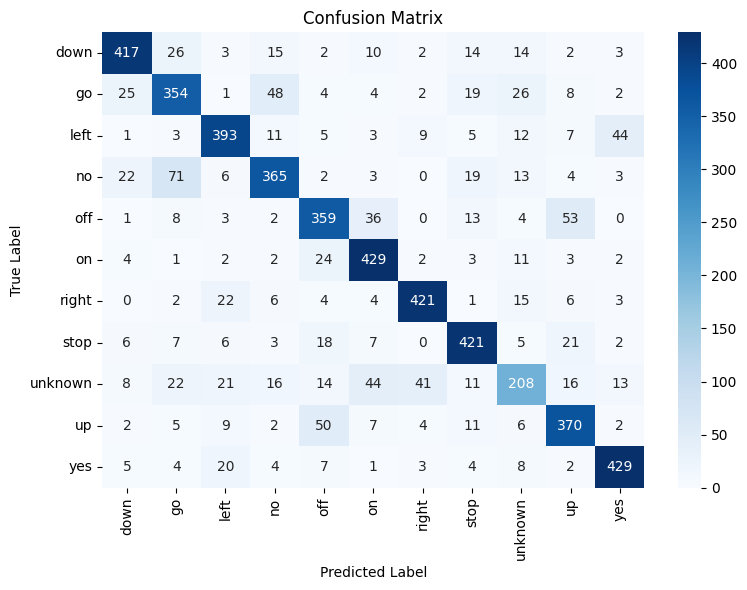

In [13]:

import time
model = SimpleCNN()
initialize_weights(model)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Jeśli używasz CUDA, ustaw również seed dla GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Dla wszystkich urządzeń CUDA
    torch.backends.cudnn.deterministic = True  # Zapewnia deterministyczność
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  # <-- Przesyłanie X na odpowiednie urządzenie
        Y = batch_Y.to(device, non_blocking=True)  # <-- Przesyłanie Y na odpowiednie urządzenie
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():  # Wyłączenie śledzenia gradientów
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Zbieranie predykcji i prawdziwych etykiet
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Precision i Recall per klasa
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

    # Pobierz nazwy klas
    classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

    # Tabelka z wynikami
    df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [17]:
from torchvision.models import vit_b_16
model = vit_b_16()

In [18]:
model.conv_proj = nn.Conv2d(1, model.conv_proj.out_channels, 
                            kernel_size=model.conv_proj.kernel_size, 
                            stride=model.conv_proj.stride, 
                            padding=model.conv_proj.padding)
model.heads.head = nn.Linear(model.heads.head.in_features, 11)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
initialize_weights(model)
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Dataloading...
Epoch 1, Average Loss: 2.30366, Accuracy: 19.70%, last batch accuracy: 23.08% Time: 1.44s
Epoch 1, Train Accuracy: 19.70%
Epoch 1, Validation Loss: 1.9444, Accuracy: 30.36%
Epoch 2, Average Loss: 1.80400, Accuracy: 36.76%, last batch accuracy: 46.15% Time: 1.07s
Epoch 2, Train Accuracy: 36.76%
Epoch 2, Validation Loss: 1.5813, Accuracy: 43.75%
Epoch 3, Average Loss: 1.58311, Accuracy: 44.59%, last batch accuracy: 69.23% Time: 1.12s
Epoch 3, Train Accuracy: 44.59%
Epoch 3, Validation Loss: 1.4479, Accuracy: 49.20%
Epoch 4, Average Loss: 1.42977, Accuracy: 50.14%, last batch accuracy: 38.46% Time: 1.07s
Epoch 4, Train Accuracy: 50.14%
Epoch 4, Validation Loss: 1.4129, Accuracy: 50.95%
Epoch 5, Average Loss: 1.27566, Accuracy: 55.39%, last batch accuracy: 76.92% Time: 1.07s
Epoch 5, Train Accuracy: 55.39%
Epoch 5, Validation Loss: 1.2333, Accuracy: 56.99%
Epoch 6, Average Loss: 1.13644, Accuracy: 59.85%, last batch accuracy: 61.54% Time: 1.07s
Epoch 6, Train Accuracy: 59.85

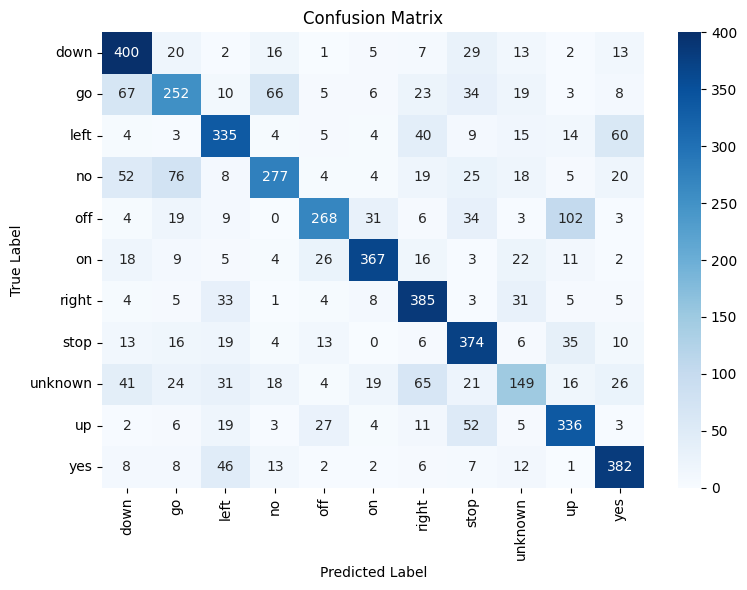

In [19]:

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Jeśli używasz CUDA, ustaw również seed dla GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Dla wszystkich urządzeń CUDA
    torch.backends.cudnn.deterministic = True  # Zapewnia deterministyczność
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  # <-- Przesyłanie X na odpowiednie urządzenie
        Y = batch_Y.to(device, non_blocking=True)  # <-- Przesyłanie Y na odpowiednie urządzenie
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():  # Wyłączenie śledzenia gradientów
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Zbieranie predykcji i prawdziwych etykiet
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Precision i Recall per klasa
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

    # Pobierz nazwy klas
    classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

    # Tabelka z wynikami
    df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()